In [1]:
import librosa
import librosa.display
import glob
import os, json, random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sub_dirs = ['1', '2', '3', '4', '5']
parent_dir = 'Data'
file_ext="*.wav" # change to "*.wav" to read all voices
samples = {1:[], 2:[], 3:[], 4:[], 5:[]}

for num, sub_dir in enumerate(sub_dirs):
    num_dir = int(sub_dir)
    for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
        sound_clip,s = librosa.load(fn)
        mfcc = librosa.feature.mfcc(y=sound_clip, sr=s, n_mfcc=20)
        mfcc = mfcc.T.tolist()
        samples[num_dir].append(mfcc)
        

In [3]:
def plot_mfcc(number, N=3):
    random.shuffle(samples[number])
    print('Displaying mfccs of number ' + str(number))
    for mfcc in samples[number]:
        if N == 0:
            break
        if num == number:
            plt.figure(figsize=(10, 4))
            mfcc = np.asarray(mfcc).T
            librosa.display.specshow(mfcc, x_axis='time')
            plt.colorbar()
            plt.title('MFCC')
            plt.tight_layout()
            N -= 1
    plt.show()

Displaying mfccs of number 4


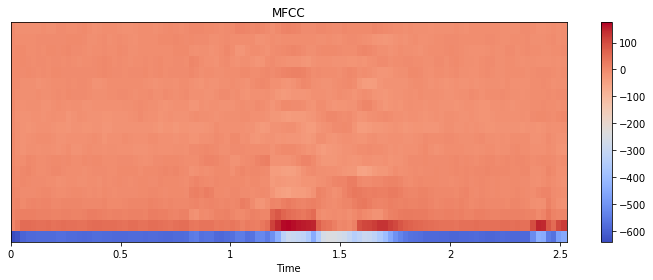

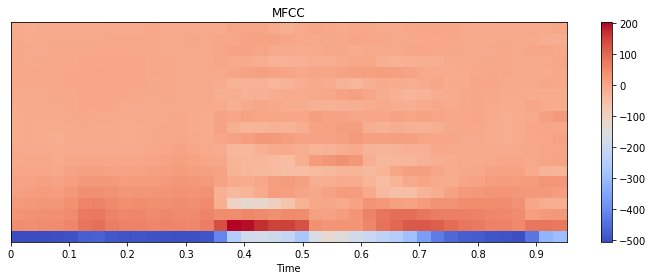

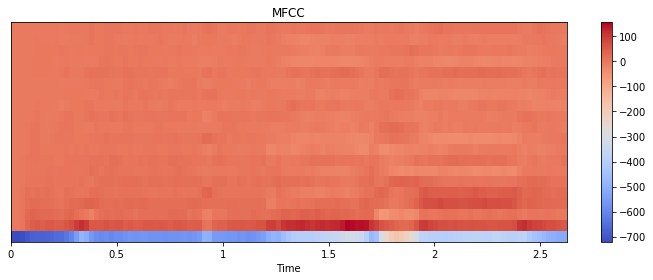

In [4]:
plot_mfcc(number=4)

In [5]:
data_path = os.path.join('Data', 'mfcc_samples.json')
f = open(data_path, "w")
json.dump(samples, f)
f.close()
